In [1]:
#!pip install opencv-python pixellib

In [2]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print(cv2.__version__)

4.11.0


## 이미지 불러오기, 크기 맞추기

고양이 이미지 크기: (2668, 2666, 3)
사막for고양이 이미지 크기: (2668, 2666, 3)
사람 이미지 크기: (2668, 2666, 3)
사막for사람 이미지 크기: (539, 960, 3)


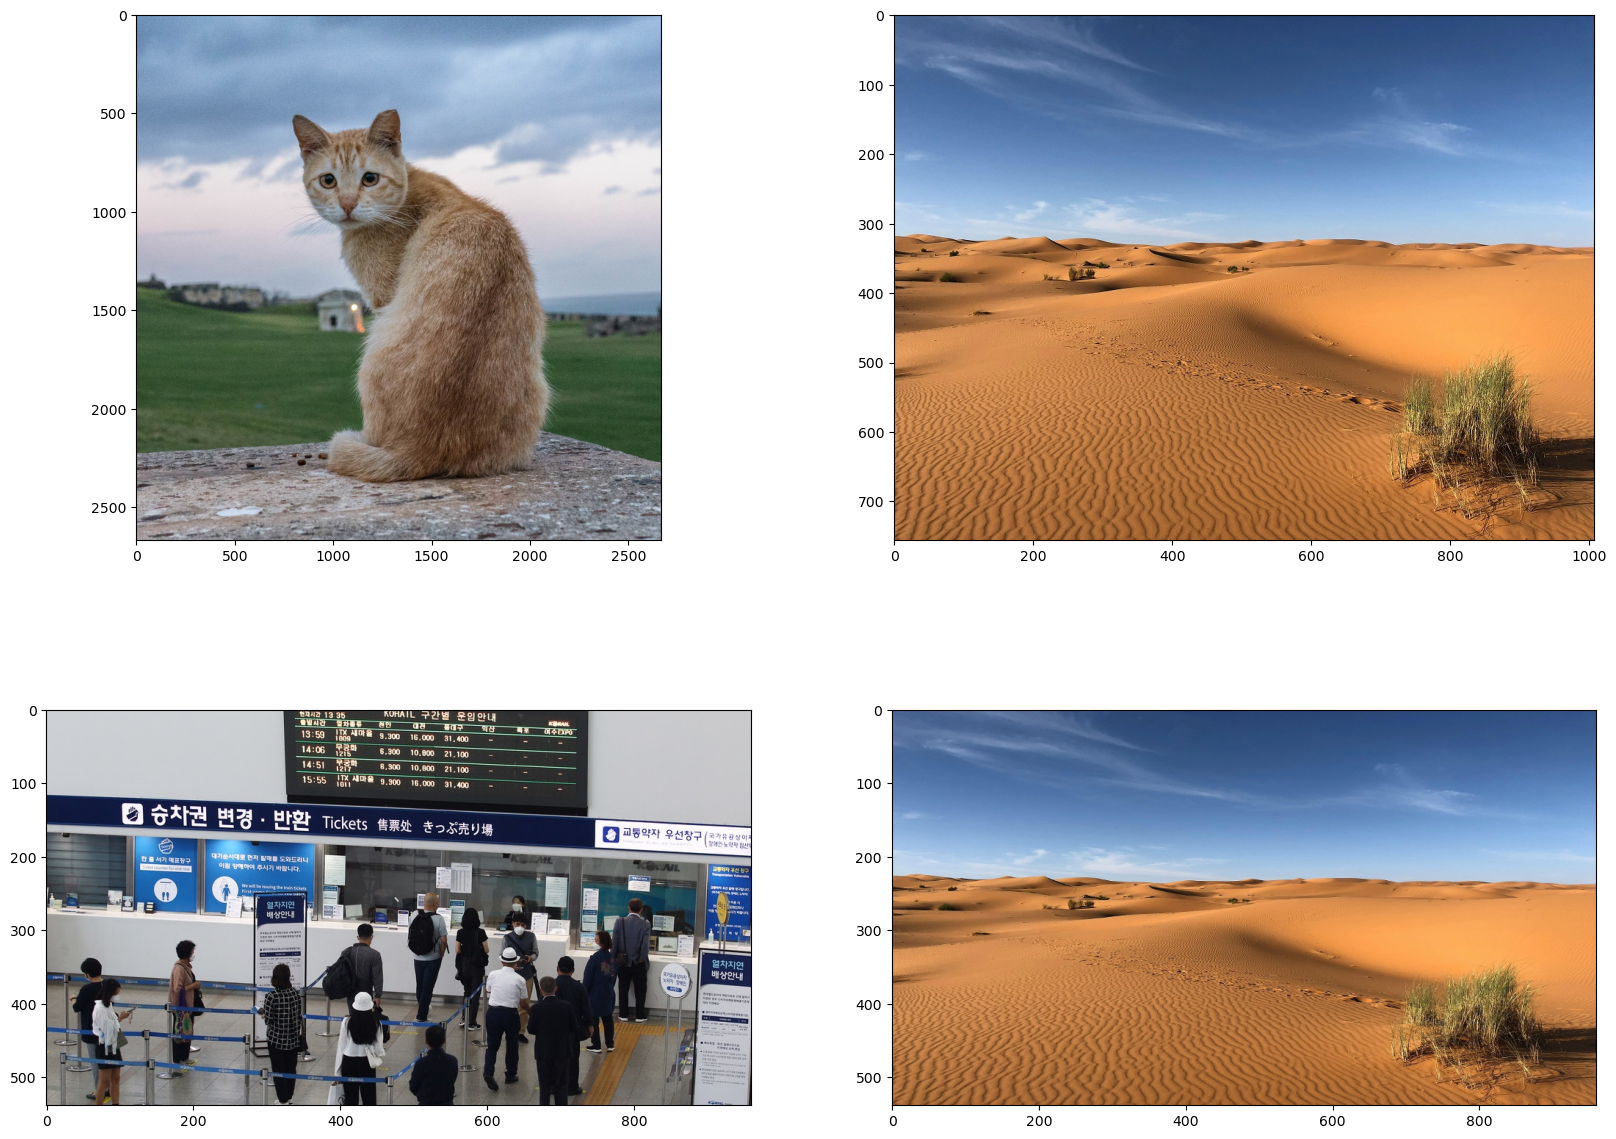

In [3]:
import os
home_dir = os.getenv('HOME')
cat_img_path = os.path.join(home_dir, "work/human_segmentation/images/cat.jpg")
human_img_path = os.path.join(home_dir, "work/human_segmentation/images/human.jpg")
sand_img_path = os.path.join(home_dir, "work/human_segmentation/images/sand.jpg")

cat_img = cv2.imread(cat_img_path)
human_img = cv2.imread(human_img_path)
sand_img = cv2.imread(sand_img_path)

cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
human_img = cv2.cvtColor(human_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

# 배경을 고양이/사람 이미지 크기에 맞춤
cat_sand_img = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))
human_sand_img= cv2.resize(sand_img, (human_img.shape[1], human_img.shape[0]))

print(f"고양이 이미지 크기: {cat_img.shape}")
print(f"사막for고양이 이미지 크기: {cat_sand_img.shape}")
print(f"사람 이미지 크기: {cat_img.shape}")
print(f"사막for사람 이미지 크기: {human_sand_img.shape}")

plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1); plt.imshow(cat_img)
plt.subplot(2, 2, 2); plt.imshow(sand_img)
plt.subplot(2, 2, 3); plt.imshow(human_img)
plt.subplot(2, 2, 4); plt.imshow(human_sand_img)
plt.show()

## 모델 추론, 마스크 만들기

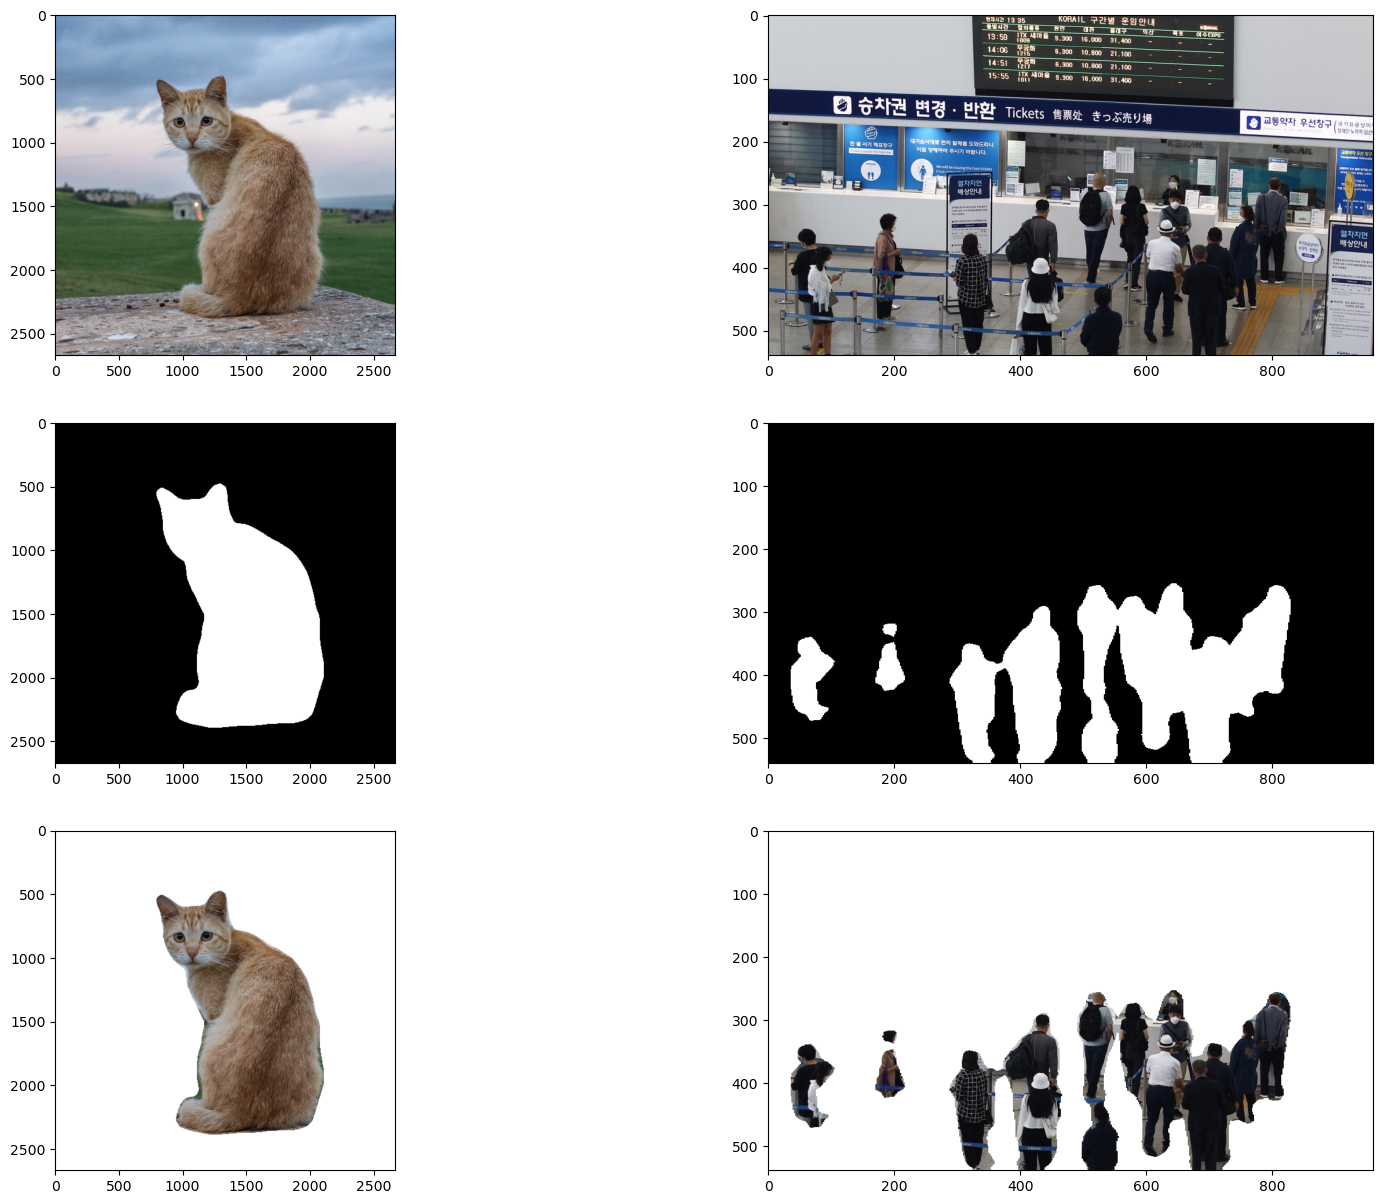

In [6]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor_cat = transform(cat_img).unsqueeze(0)
input_tensor_human = transform(human_img).unsqueeze(0)

with torch.no_grad():
    output_cat = model(input_tensor_cat)["out"][0]
    output_predictions_cat = output_cat.argmax(0).byte().cpu().numpy()
    output_human = model(input_tensor_human)["out"][0]
    output_predictions_human = output_human.argmax(0).byte().cpu().numpy()

# 마스크를 원본 크기로 Resize
out_pred_cat_resized = cv2.resize(output_predictions_cat, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)
out_pred_human_resized = cv2.resize(output_predictions_human, (human_img.shape[1], human_img.shape[0]), interpolation=cv2.INTER_NEAREST)
#--------------
#예측된 클래스 ID
uniq_clas_cat = np.unique(out_pred_cat_resized); tg_cls_id_cat = uniq_clas_cat[-1]
uniq_clas_human = np.unique(out_pred_human_resized); tg_cls_id_human = uniq_clas_human[-1]
#--------------

seg_map_cat = (out_pred_cat_resized == tg_cls_id_cat)
img_mask_cat = seg_map_cat.astype(np.uint8) * 255
img_mask_color_cat = cv2.cvtColor(img_mask_cat, cv2.COLOR_GRAY2BGR)  # 3채널 변환
seg_map_human = (out_pred_human_resized == tg_cls_id_human)
img_mask_human = seg_map_human.astype(np.uint8) * 255
img_mask_color_human = cv2.cvtColor(img_mask_human, cv2.COLOR_GRAY2BGR)  # 3채널 변환

white_img_cat = np.full_like(cat_img,255) #np.zeros_like(cat_img)
result_img_cat = np.where(img_mask_color_cat == 255, cat_img, white_img_cat)  # 마스크 기반 합성
white_img_human = np.full_like(human_img,255)
result_img_human = np.where(img_mask_color_human == 255, human_img, white_img_human)  # 마스크 기반 합성

plt.figure(figsize=(20, 15))
plt.subplot(3, 2, 1); plt.imshow(cat_img)
plt.subplot(3, 2, 2); plt.imshow(human_img)

plt.subplot(3, 2, 3); plt.imshow(img_mask_cat, cmap='gray')
plt.subplot(3, 2, 4); plt.imshow(img_mask_human, cmap='gray')

plt.subplot(3, 2, 5); plt.imshow(result_img_cat)
plt.subplot(3, 2, 6); plt.imshow(result_img_human)
plt.show()

## 배경 블러처리 하기 & 배경 교체하기

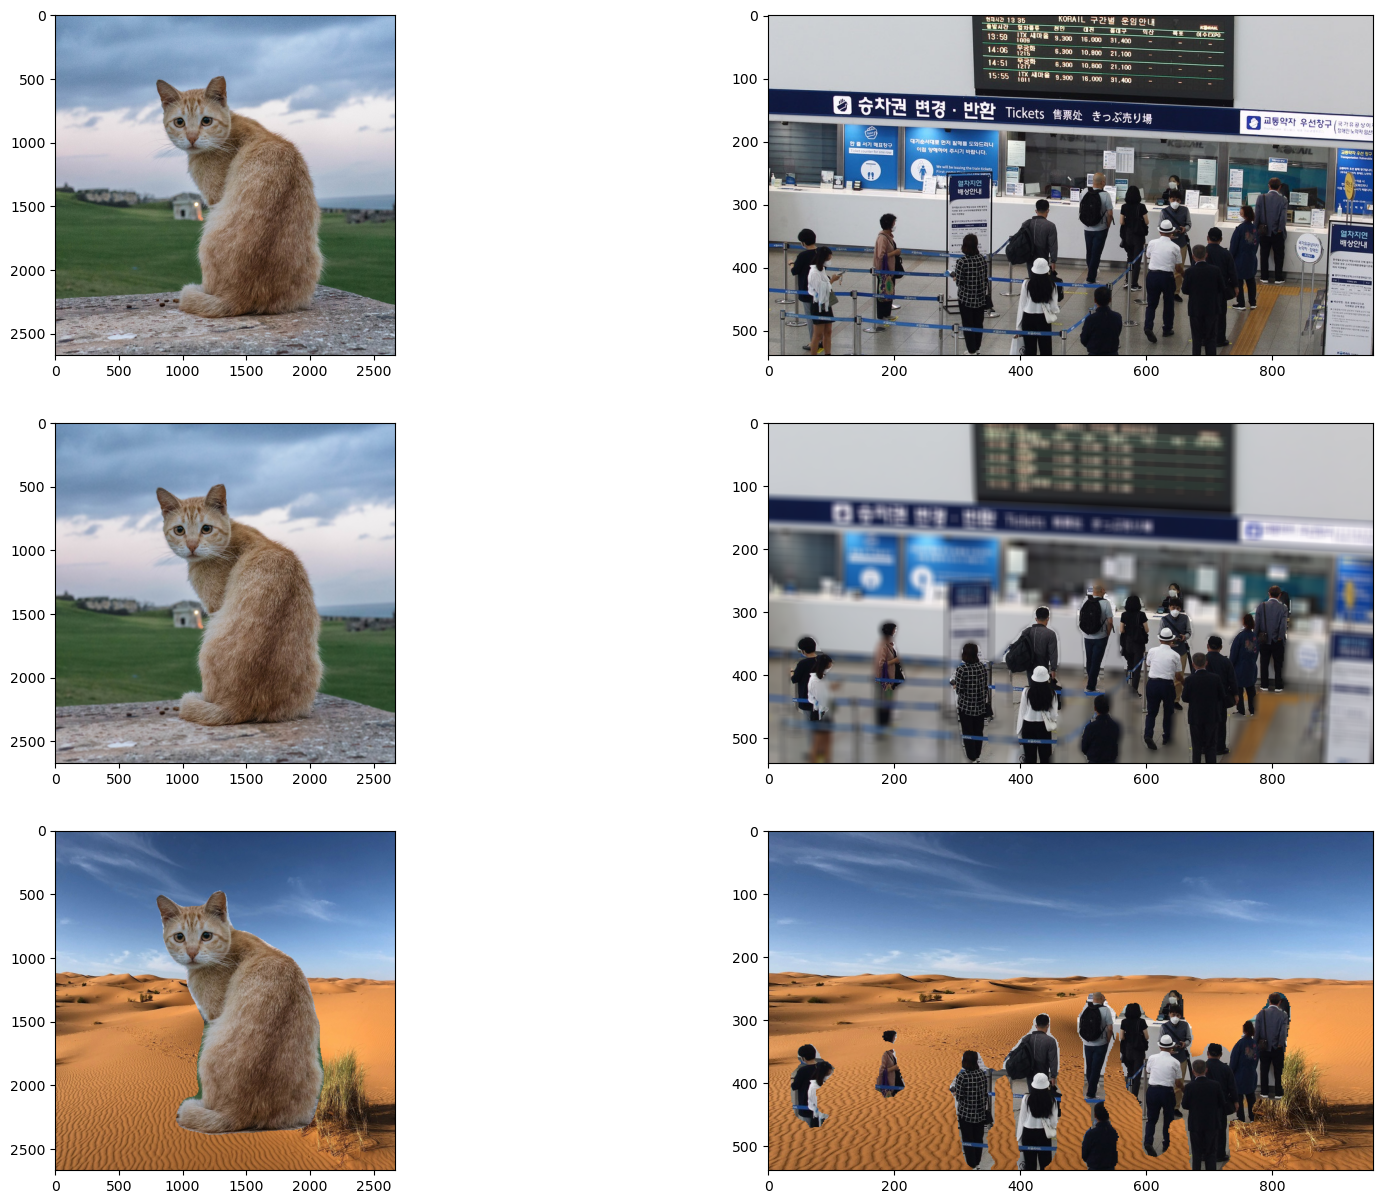

In [5]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
cat_img_blur = cv2.blur(cat_img, (13, 13))
blur_cat_img = np.where(img_mask_color_cat == 255, cat_img, cat_img_blur)  # 마스크 기반 합성
sand_cat_img = np.where(img_mask_color_cat == 255, cat_img, cat_sand_img)  # 마스크 기반 합성

human_img_blur = cv2.blur(human_img, (13, 13))
blur_human_img = np.where(img_mask_color_human == 255, human_img, human_img_blur)  # 마스크 기반 합성
sand_human_img = np.where(img_mask_color_human == 255, human_img, human_sand_img)  # 마스크 기반 합성


plt.figure(figsize=(20, 15))
plt.subplot(3, 2, 1); plt.imshow(cat_img)
plt.subplot(3, 2, 2); plt.imshow(human_img)

plt.subplot(3, 2, 3); plt.imshow(blur_cat_img)
plt.subplot(3, 2, 4); plt.imshow(blur_human_img)

plt.subplot(3, 2, 5); plt.imshow(sand_cat_img)
plt.subplot(3, 2, 6); plt.imshow(sand_human_img)
plt.show()

# <결과 분석>

### 1. 결과
아웃포커싱 효과와 배경전환 결과<br>
<img src="result1.png">

### 2. 문제점

<img src="result2.png">

고양이의 경우는 꽤 잘 구분했지만,<br>
사람의 경우는 잘리거나 배경이 분류되는 경우가 많았다<br>
<br>
고양이의 경우는 피사체가 크고 경계가 꽤 확실해서 잘 구분한 것을 보인다.<br>
사람의 경우, 검출이 잘 안된 가장 큰 이유는 피사체의 크기가 작았기 때문으로 보인다.<br>

### 3. 보완책과 이유<br>
3-1. 크기 문제 (Image Pyramids 적용)<br>
사람의 경우 피사체의 크기가 작았던 문제라면,<br>
앞서 detector_hog에서 나왔던 Image Pyramids를 적용하면<br>
작은것도 크게 볼 수 있기 때문에 보다 더 정확한 검출이 가능했을 것이라 예상된다.<br>
<br>
3-2. 파편화 문제<br>
다른 사람 이미지로 해봤을 때,<br>
중간중간 사람이 아닌 작게 파편화된 결과들이 종종 보였는데,<br>
이는, 서로 떨어진 segmentation의 크기를 계산해서 분포를 확인하고<br>
너무 작은것은 필터링 하는 등의 방법을 생각해 볼 수 있을것 같다. 

# <회고>

코드를 좀 더 모듈화 하고 잘 정리할 수 있었다.<br>
결과를 개선하는 방법도 입력 이미지 전처리, Image pyramids 적용, segmentation의 면적을 계산해서 반영하는 등...<br>
다양한 아이디어가 있었다.<br>
하지만~, 적용하지 못했다. 너무너무 피곤했다. 오늘은 빨리 끝내고 자고 싶었다. ㅠㅠ<br>
그래서,<br>
Segmentation 기법을 활용해보고 해결책을 찾아보고 제시해본 것으로 아쉬운 마무리를 한다.<br>